In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import csv
# Import the necessary functions from utils.py
from utils import write_pajek_communities, generate_pajek_communities



Moved 0 files to the SBM folder


In [3]:
def load_networks(path='SBM'):
    """
    Load networks from Pajek files.
    
    Returns:
    dict: Dictionary containing the loaded networks
    """
    # Load networks from Pajek files
    networks = {}
    for name in ['ER_4', 'ER_6', 'BA_4', 'BA_6']:
        networks[name] = nx.Graph(nx.read_pajek(os.path.join('SBM', f"{name}.net")))
    return networks
networks = load_networks()

In [4]:
def MMCA_SIS_model(G, lambda_val, mu, max_iterations=1000, convergence_threshold=1e-6, initital_infection_prob=0.05):
    """
    Implements the Microscopic Markov Chain Approach (MMCA) for the SIS model.
    
    Parameters:
    G (networkx.Graph): Network to analyze
    lambda_val (float): Infection probability per contact
    mu (float): Recovery probability
    max_iterations (int): Maximum number of iterations
    convergence_threshold (float): Convergence criterion
    
    Returns:
    float: Steady state infected fraction
    numpy.ndarray: Probability of each node being infected at steady state
    """
    # Number of nodes
    N = G.number_of_nodes()
    
    # Initialize probability of node i being infected at time t
    p_i = np.ones(N) * initital_infection_prob  # Start with small infection probability (should produce around 50 initial infected people)
    
    # Create adjacency matrix for faster computation
    A = nx.to_numpy_array(G)
    
    # Iteratively update probabilities until convergence
    for iteration in range(max_iterations):

        # Naive approach (commented out for performance reasons)
        """p_i_new = np.zeros(N)
        
        for i in range(N):
            # Get neighbors of node i
            neighbors = np.where(A[i] > 0)[0]
            
            # Calculate probability that node i is not infected by any neighbor
            prob_not_infected = 1.0
            for j in neighbors:
                prob_not_infected *= (1 - lambda_val * p_i[j])
            
            # Update equation for the MMCA model for SIS dynamics
            p_i_new[i] = (1 - mu) * p_i[i] + (1 - p_i[i]) * (1 - prob_not_infected)"""
        
        # Vectorized approach for efficiency
        # Create matrix of probabilities (1 - λp_j) for all nodes
        prob_matrix = 1 - lambda_val * np.outer(np.ones(N), p_i)
        
        # Multiply only where there are edges (element-wise with adjacency matrix)
        prob_matrix = np.where(A > 0, prob_matrix, 1)
        
        # Calculate probability of not being infected by taking product along neighbors
        prob_not_infected = np.prod(prob_matrix, axis=1)
        
        # Update equation for the MMCA model for SIS dynamics
        p_i_new = (1 - mu) * p_i + (1 - p_i) * (1 - prob_not_infected)
        
        # Check for convergence
        delta = np.max(np.abs(p_i_new - p_i))
        p_i = p_i_new.copy()
        
        if delta < convergence_threshold:
            print(f"MMCA converged after {iteration+1} iterations")
            break
        
            
    if iteration == max_iterations - 1:
        print(f"MMCA reached maximum iterations ({max_iterations}) without converging")
    
    # Calculate steady state infected fraction (ρ)
    steady_state_infected = np.mean(p_i)
    
    return steady_state_infected, p_i

def run_mmca_simulations(networks, lambda_values, mu_values):
    """
    Run MMCA simulations for the provided networks and parameter combinations
    
    Parameters:
    networks (dict): Dictionary of networks to analyze
    lambda_values (array): Array of lambda values to simulate
    mu_values (list): List of mu values to simulate
    
    Returns:
    dict: Dictionary containing MMCA results
    """
    # Dictionary to store results
    results = {}
    
    # Run simulations for each combination of parameters
    print("Running MMCA simulations...")
    start_time = time.time()
    
    for mu in mu_values:
        results[mu] = {}
        for network_name, G in networks.items():
            results[mu][network_name] = {
                'mmca_values': []
            }
            
            for lambda_val in lambda_values:
                print(f"MMCA: μ={mu}, network={network_name}, λ={lambda_val:.2f}")
                
                # Run MMCA model
                mmca_result, _ = MMCA_SIS_model(G, lambda_val, mu)
                
                # Store result
                results[mu][network_name]['mmca_values'].append(mmca_result)
                
                print(f"  MMCA ρ = {mmca_result:.4f}")
    
    # Report execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTotal MMCA execution time: {execution_time:.2f} seconds")
    
    # Export results to CSV
    export_mmca_results_to_csv(results, lambda_values, mu_values)
    
    return results

def export_mmca_results_to_csv(results, lambda_values, mu_values):
    """
    Export MMCA simulation results to CSV files
    
    Parameters:
    results (dict): Dictionary containing the MMCA simulation results
    lambda_values (array): Array of lambda values used in simulations
    mu_values (list): List of mu values used in simulations
    """
    # Create a directory for CSV files if it doesn't exist
    csv_dir = "mmca_results_csv"
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)
    
    # Export summary results for each mu value
    for mu in mu_values:
        with open(os.path.join(csv_dir, f'mmca_results_mu_{mu}.csv'), 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write header
            header = ['lambda'] + list(results[mu].keys())
            writer.writerow(header)
            
            # Write data
            for i, lambda_val in enumerate(lambda_values):
                row = [lambda_val]
                for network_name in results[mu].keys():
                    row.append(results[mu][network_name]['mmca_values'][i])
                writer.writerow(row)
    
    # Export combined results for all mu values
    with open(os.path.join(csv_dir, 'mmca_combined_results.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header
        header = ['lambda']
        for mu in mu_values:
            for network_name in results[mu].keys():
                header.append(f'{network_name}_mu_{mu}')
        writer.writerow(header)
        
        # Write data
        for i, lambda_val in enumerate(lambda_values):
            row = [lambda_val]
            for mu in mu_values:
                for network_name in results[mu].keys():
                    row.append(results[mu][network_name]['mmca_values'][i])
            writer.writerow(row)
    
    print(f"MMCA results exported to CSV files in the '{csv_dir}' directory")



# Define parameter ranges (same as in your Monte Carlo simulations)
lambda_values = np.arange(0, 0.31, 0.01)
mu_values = [0.2, 0.4]

# Run MMCA simulations
mmca_results = run_mmca_simulations(networks, lambda_values, mu_values)

Running MMCA simulations...
MMCA: μ=0.2, network=ER_4, λ=0.00
MMCA converged after 43 iterations
  MMCA ρ = 0.0000
MMCA: μ=0.2, network=ER_4, λ=0.01
MMCA converged after 63 iterations
  MMCA ρ = 0.0000
MMCA: μ=0.2, network=ER_4, λ=0.02
MMCA converged after 97 iterations
  MMCA ρ = 0.0000
MMCA: μ=0.2, network=ER_4, λ=0.03
MMCA converged after 196 iterations
  MMCA ρ = 0.0000
MMCA: μ=0.2, network=ER_4, λ=0.04
MMCA converged after 778 iterations
  MMCA ρ = 0.0158
MMCA: μ=0.2, network=ER_4, λ=0.05
MMCA converged after 202 iterations
  MMCA ρ = 0.1249
MMCA: μ=0.2, network=ER_4, λ=0.06
MMCA converged after 145 iterations
  MMCA ρ = 0.2159
MMCA: μ=0.2, network=ER_4, λ=0.07
MMCA converged after 121 iterations
  MMCA ρ = 0.2890
MMCA: μ=0.2, network=ER_4, λ=0.08
MMCA converged after 110 iterations
  MMCA ρ = 0.3483
MMCA: μ=0.2, network=ER_4, λ=0.09
MMCA converged after 107 iterations
  MMCA ρ = 0.3971
MMCA: μ=0.2, network=ER_4, λ=0.10
MMCA converged after 108 iterations
  MMCA ρ = 0.4380
MMCA: μ

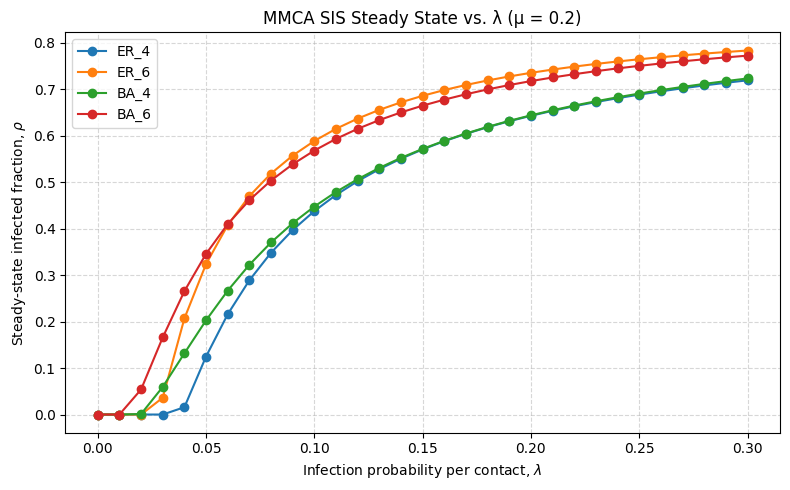

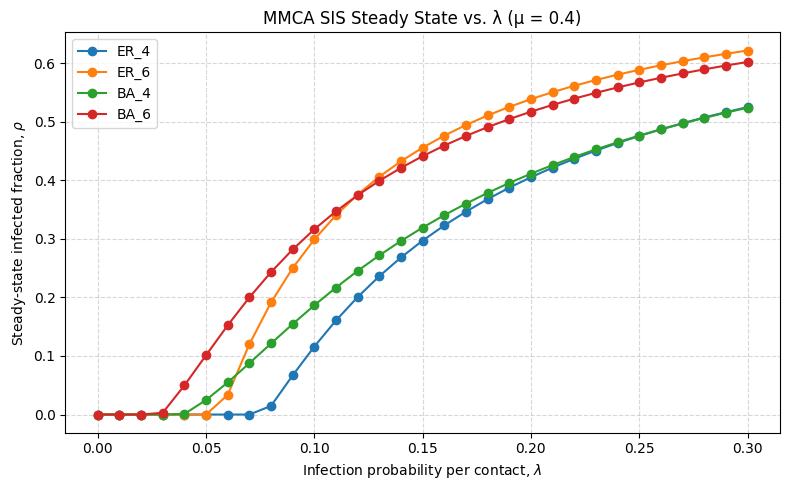

In [5]:
import matplotlib.pyplot as plt

def plot_mmca_results(results, lambda_values, mu_values):
    """
    Plots steady‐state infected fraction vs lambda for each network and mu.
    
    Parameters:
    -----------
    results : dict
        Output of run_mmca_simulations, keyed by mu and network name.
    lambda_values : array‐like
        The array of lambda values used in the simulations.
    mu_values : list
        The list of mu values used in the simulations.
    """
    for mu in mu_values:
        plt.figure(figsize=(8, 5))
        for network_name, data in results[mu].items():
            plt.plot(lambda_values,
                     data['mmca_values'],
                     marker='o',
                     label=network_name)
        
        plt.xlabel(r'Infection probability per contact, $\lambda$')
        plt.ylabel(r'Steady‐state infected fraction, $\rho$')
        plt.title(f'MMCA SIS Steady State vs. λ (μ = {mu})')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


# Example usage (after you’ve run run_mmca_simulations):
plot_mmca_results(mmca_results, lambda_values, mu_values)
